## Sprite Text2Img Attention Experiments
Tries to apply attention to the text to image sprites

Based on the tutorial found here: https://www.tensorflow.org/tutorials/text/image_captioning

---


### Imports and Configuration

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

# tensorflow
import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, Conv2DTranspose, Flatten, Layer, Reshape, Input, LeakyReLU, MaxPooling2D, Concatenate, Conv1D, Lambda, BatchNormalization, UpSampling2D, Add, GRU
from tensorflow.keras.models import Model


%matplotlib inline

In [2]:
#import from Python folder to get the utils
import sys
sys.path.append('../Python')
from utils import picoSS2np, showMultiSprPalette, showMultiSprRGB, showSprRGB, showSprPalette, animatePal, encodeSpr1H, decodeSpr1H, showTxtEmb

In [3]:
### CONSTANT VARIABLES   ###

# PICO-8 Palette => use colormap for matplotlib
PICO_PALETTE = ['#000000','#1D2B53','#7E2553','#008751','#AB5236','#5F574F','#C2C3C7','#FFF1E8','#FF004D','#FFA300','#FFEC27','#00E436','#29ADFF','#83769C','#FF77A8','#FFCCAA']


Food Dataset shape: (100, 8, 8)
Char Dataset shape: (100, 8, 8)


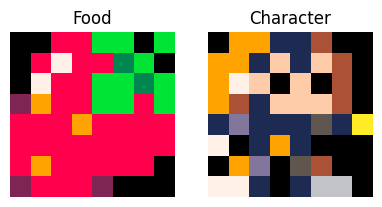

In [4]:
# import from the PICO sprites posted onto Twitter 
# Food: https://twitter.com/JUSTIN_CYR/status/634546317713391616
# Characters: https://twitter.com/johanvinet/status/635814153601597441
pico_food_dat = np.load('../data/rip_data/pico_food.npy',allow_pickle=True)
pico_char_dat = np.load('../data/rip_data/pico_characters.npy',allow_pickle=True)

print(f"Food Dataset shape: {pico_food_dat.shape}")
print(f"Char Dataset shape: {pico_char_dat.shape}")

# show a random food and character sprite 
rand_food = random.choice(pico_food_dat)
rand_char = random.choice(pico_char_dat)
showMultiSprPalette([rand_food,rand_char],textArr=['Food','Character'])

In [5]:
# import sentence-transformer for text embedding 
SBERT_MODEL = SentenceTransformer('bert-base-nli-mean-tokens')

def sentEmb(txt):
    return SBERT_MODEL.encode([txt])[0]

# import the text data
pico_char_labels = np.array([l.strip() for l in open('../data/rip_data/character_desc.txt','r').readlines()])

# encode the labels
pico_char_emb = []
with tqdm(total=len(pico_char_labels)) as pbar:
    pbar.set_description("Encoding labels")
    for l in pico_char_labels:
        pico_char_emb.append(sentEmb(l))
        pbar.update(1)

pico_char_emb = np.array(pico_char_emb)

Encoding labels: 100%|██████████| 100/100 [00:07<00:00, 13.79it/s]


Character: a green man with yellow hair and a black robe


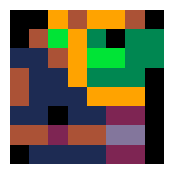

Encoding length: 768


In [6]:
# show a random character and its description
rand_char_idx = random.randint(0,len(pico_char_labels))
print(f"Character: {pico_char_labels[rand_char_idx]}")
showSprPalette(pico_char_dat[rand_char_idx])

desc_enc = pico_char_emb[rand_char_idx]
print(f"Encoding length: {len(desc_enc)}")

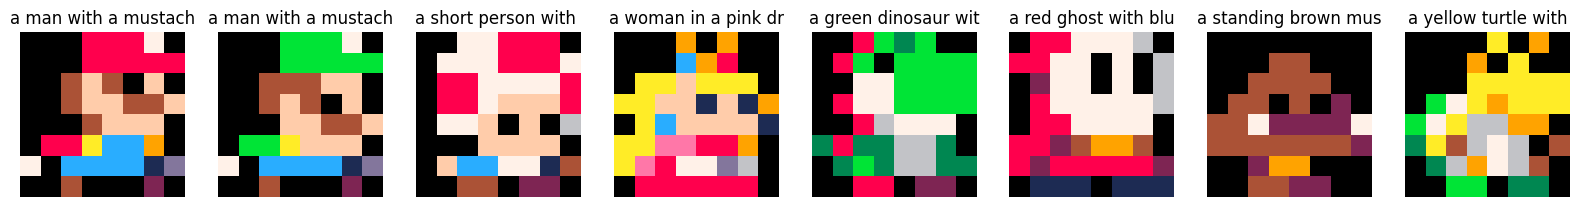

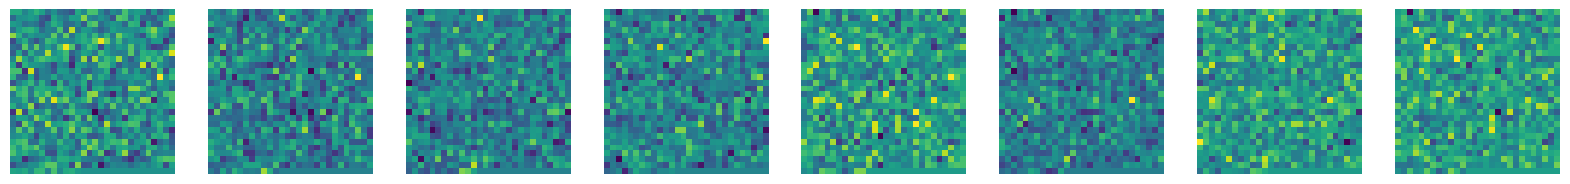

In [7]:
# show the text embedding	
showMultiSprPalette(pico_char_dat[:8],textArr=[l[:20] for l in pico_char_labels[:8]])
showTxtEmb(pico_char_emb[:8])

In [8]:
###   CONFIUGURATIONS   ###

EXPERIMENT = "tf_tutorial"

GEN_CONF = {
    "EPOCHS" : 20,
    "BATCH_SIZE" : 16,
    "LEARNING_RATE" : 0.001,
    "WINDOW" : 8,
    "REAL_TEST_INDEX": [0,7,30,53,86,90,96,99]
}

### General Setup

In [9]:
# create the training dataset (embheddings -> images)
pico_char_emb = SBERT_MODEL.encode(pico_char_labels)
pico_char_emb = np.array(pico_char_emb)

X_train = pico_char_emb
Y_train = np.array([encodeSpr1H(s) for s in pico_char_dat])

print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")

X_train: (100, 768)
Y_train: (100, 8, 8, 16)


In [23]:
'''
  # Define the attention layer (Bahdanau et al. 2014)
    from various sources: 
    - https://towardsdatascience.com/image-captions-with-attention-in-tensorflow-step-by-step-927dad3569fa
    - https://www.analyticsvidhya.com/blog/2020/11/attention-mechanism-for-caption-generation/
    - https://blog.paperspace.com/seq-to-seq-attention-mechanism-keras/
'''
class Attention_B(Model):
    def __init__(self, units):
        super(Attention_B, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        # features shape == (batch_size, max_length, embedding_dim) ; features from the encoder
        # hidden shape == (batch_size, hidden size) ; hidden state from the LSTM
        # hidden_with_time_axis shape == (batch_size, 1, hidden size) ; add time axis to hidden
        # score shape == (batch_size, max_length, 1) ; gives unnormalized score for each image feature

        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, max_length, 1) ; softmax normalized scores
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size) ; weighted sum of image features
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [24]:
# test the attention layer
UNITS = 10
att_test = Attention_B(UNITS)
feat = random.choice(pico_char_emb)   # get the text features from the bert model => (1,768)
feat = tf.expand_dims(feat,0)         # add batch dimension
hidden = tf.zeros((1,UNITS))          # initial hidden state (zeros)

context_vector, attention_weights = att_test(feat, hidden)
print(f"[INPUT SHAPES] feat (batch, emb_dim): {feat.shape} ; hidden (batch, units): {hidden.shape}")
print(f"[OUTPUT SHAPES] ctx_vec (batch, units): {context_vector.shape} ; att_weights (batch, max_len, 1): {attention_weights.shape}")
print(f"[VALUES] ctx_vec: {context_vector} ; att_weights: {attention_weights}")


[INPUT SHAPES] feat (batch, emb_dim): (1, 768) ; hidden (batch, units): (1, 10)
[OUTPUT SHAPES] ctx_vec (batch, units): (1, 768) ; att_weights (batch, max_len, 1): (1, 1, 1)
[VALUES] ctx_vec: [[-4.63554502e-01  3.20823133e-01 -1.87517786e+00  2.19594762e-01
  -8.34941864e-02 -1.27695113e-01 -3.75838012e-01 -7.57593870e-01
  -6.56138957e-01 -9.55195427e-01 -1.04143417e+00  4.84258294e-01
   1.09269135e-01  1.34223521e-01  8.95517230e-01  3.07941943e-01
  -3.69403839e-01  4.59283069e-02 -3.02890271e-01  8.09169233e-01
  -6.97310984e-01  3.30336630e-01  6.03856385e-01 -5.44211507e-01
   5.05485952e-01  4.75359887e-01 -1.07089542e-01  1.61902082e+00
  -5.47194123e-01  3.34878951e-01  4.81399924e-01  5.25161862e-01
  -9.30567011e-02 -9.90150094e-01 -1.92480135e+00 -2.98951626e-01
  -8.90214622e-01 -3.82314622e-01  3.24143112e-01 -2.82738537e-01
   9.42856729e-01  1.06733151e-01 -5.63660026e-01  6.91059411e-01
   8.93461704e-02 -7.04448462e-01 -4.84590024e-01 -3.70159030e-01
  -1.10649872e+0

In [26]:
# define the decoder model
# from https://towardsdatascience.com/image-captions-with-attention-in-tensorflow-step-by-step-927dad3569fa
class AttBDec(Model):
    def __init__(self, txt_emb_dim, units, out_emb_dim):
        super(AttBDec, self).__init__()
        self.units = units
        self.embedding = Dense(txt_emb_dim)
        self.attention = Attention_B(self.units)
        self.gru = GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc1 = Dense(self.units)
        self.fc2 = Dense(out_emb_dim)

    def call(self, x, features, hidden):
        ctx_vec, attn_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(ctx_vec, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attn_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [27]:
# encoder for the text embeddings ; used for positional encoding from the frozen model
# might need to be changed (this was intended for image-to-caption system)
# taken from https://towardsdatascience.com/image-captions-with-attention-in-tensorflow-step-by-step-927dad3569fa
# and https://towardsdatascience.com/implementing-neural-machine-translation-with-attention-using-tensorflow-fc9c6f26155f
class AttBEnc(Model):
    def __init__(self, txt_emb_dim):
        super(AttBEnc, self).__init__()
        self.fc = Dense(txt_emb_dim)
        # self.embedding = tf.keras.layers.Embedding(1000, txt_emb_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
# just try with the decoder first why not lol
# taken from https://towardsdatascience.com/image-captions-with-attention-in-tensorflow-step-by-step-927dad3569fa

# configs and whatnot
EMB_DIM = 256
UNITS = 10
OUT_EMB_DIM = 64
STEPS = len(X_train)
BATCH_SIZE = GEN_CONF["BATCH_SIZE"]
EPOCHS = GEN_CONF["EPOCHS"]

# output from word encoding
feat_shape = pico_char_emb.shape[1]
print(f"feat_shape: {feat_shape}")
attn_feat_shape = 1 
print(f"attn_feat_shape: {attn_feat_shape}")

opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_func(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    loss_ = loss(y_true, y_pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

@tf.function
def train_step(text_enc_in, img_target):

